In [1]:
from PIL import Image
import numpy as np
import os
from rawkit.raw import Raw
import scipy
from mpldatacursor import datacursor
from scipy import ndimage
import warnings,glob
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %matplotlib nbagg
    import matplotlib.pyplot as plt
    import matplotlib
files = glob.glob("neb/*.cr2")
print(len(files))

30


In [94]:
dark = np.load("dark.npy")

In [104]:
flat = np.load("flat.npy")

In [13]:
filename = files[0]
with Raw(filename=filename) as raw:
    nebula, cdesc = raw.bayer_data(include_margin=False)
nebula = np.array(nebula)

<IPython.core.display.Javascript object>


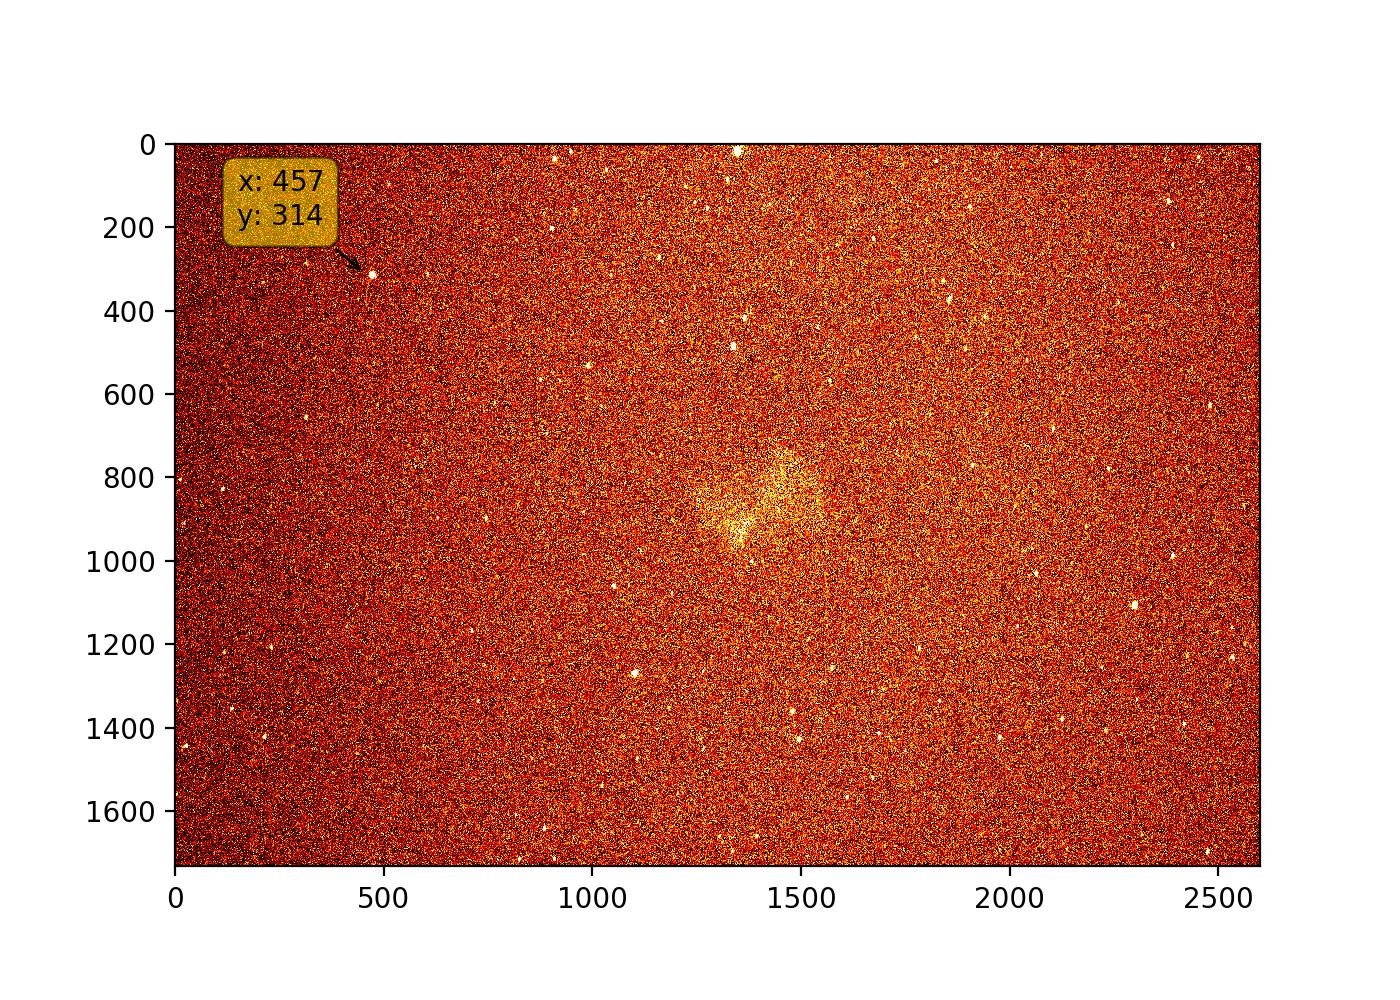

In [14]:
f = files[0]
fig, ax = plt.subplots(figsize=(7,5))
blue = nebula[::2,::2]
ax.imshow(blue, cmap="hot",vmin=np.percentile(blue,10),vmax=np.percentile(blue,99))
dc = datacursor(ax)

In [15]:
for k in dc.annotations:
    ry, rx = dc.annotations[k].xy
    print(rx, ry)
radius = 200

313.587154378 457.296975806


In [17]:
def cmask(x,y,radius,shape):
    nx,ny = shape
    y,x = np.ogrid[-x:nx-x,-y:ny-y]
    mask = x*x + y*y >= radius*radius
    return mask
mask = cmask(rx,ry,radius,blue.shape)
blurred = scipy.ndimage.filters.gaussian_filter(blue, sigma=10)
am = np.argmax(np.ma.masked_array(blurred,mask))
refx, refy = np.unravel_index(am,blue.shape)
print(refx,refy)

315 474


In [105]:
sr, sg, sb, su = None, None, None, None
shifts = np.zeros((len(files),2))
for j,f in enumerate(files):
    #i = np.average((np.array(Image.open(f), dtype=np.float32)),axis=2)
    with Raw(filename=f) as raw:
        nebula, cdesc = raw.bayer_data(include_margin=False)
    nebula = (np.array(nebula,dtype=np.int64)-dark)/flat
    
    ir, ig, ib, iu = nebula[::2,::2], nebula[1::2,::2], nebula[::2,1::2], nebula[1::2,1::2]
    blurred = scipy.ndimage.filters.gaussian_filter(ir, sigma=10)
    am = np.argmax(np.ma.masked_array(blurred,mask))
    ix, iy = np.unravel_index(am,ir.shape)
    shifts[j] = [ix-refx,iy-refy]
    ir = np.roll(ir,-iy+refy,axis=1)
    ir = np.roll(ir,-ix+refx,axis=0)
    ig = np.roll(ig,-iy+refy,axis=1)
    ig = np.roll(ig,-ix+refx,axis=0)    
    ib = np.roll(ib,-iy+refy,axis=1)
    ib = np.roll(ib,-ix+refx,axis=0)        
    iu = np.roll(iu,-iy+refy,axis=1)
    iu = np.roll(iu,-ix+refx,axis=0)        
    if sr is None:
        sr = ir
        sg = ig
        sb = ib
        su = iu
    else:
        sr += ir
        sg += ig
        sb += ib
        su += iu
sr = sr[:-1,:]
sb = sb[:-1,:]

<IPython.core.display.Javascript object>


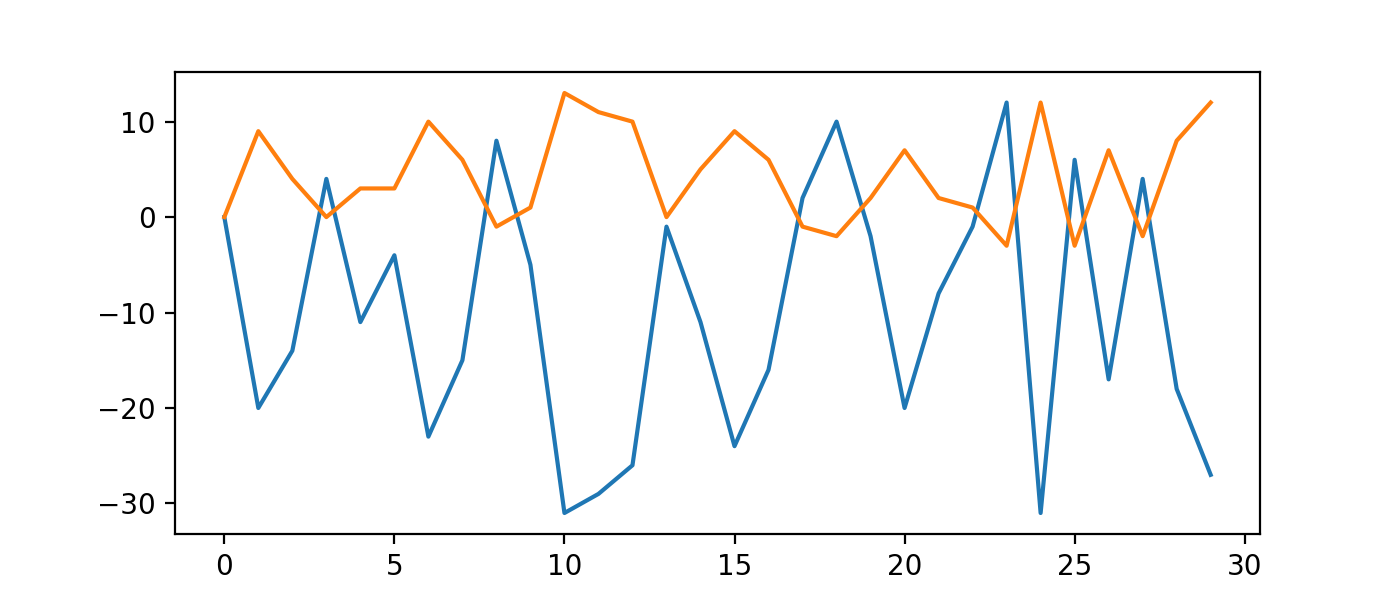

In [106]:
fig, ax = plt.subplots(figsize=(7,3))
ax.plot(shifts[:,0])
ax.plot(shifts[:,1])

<IPython.core.display.Javascript object>


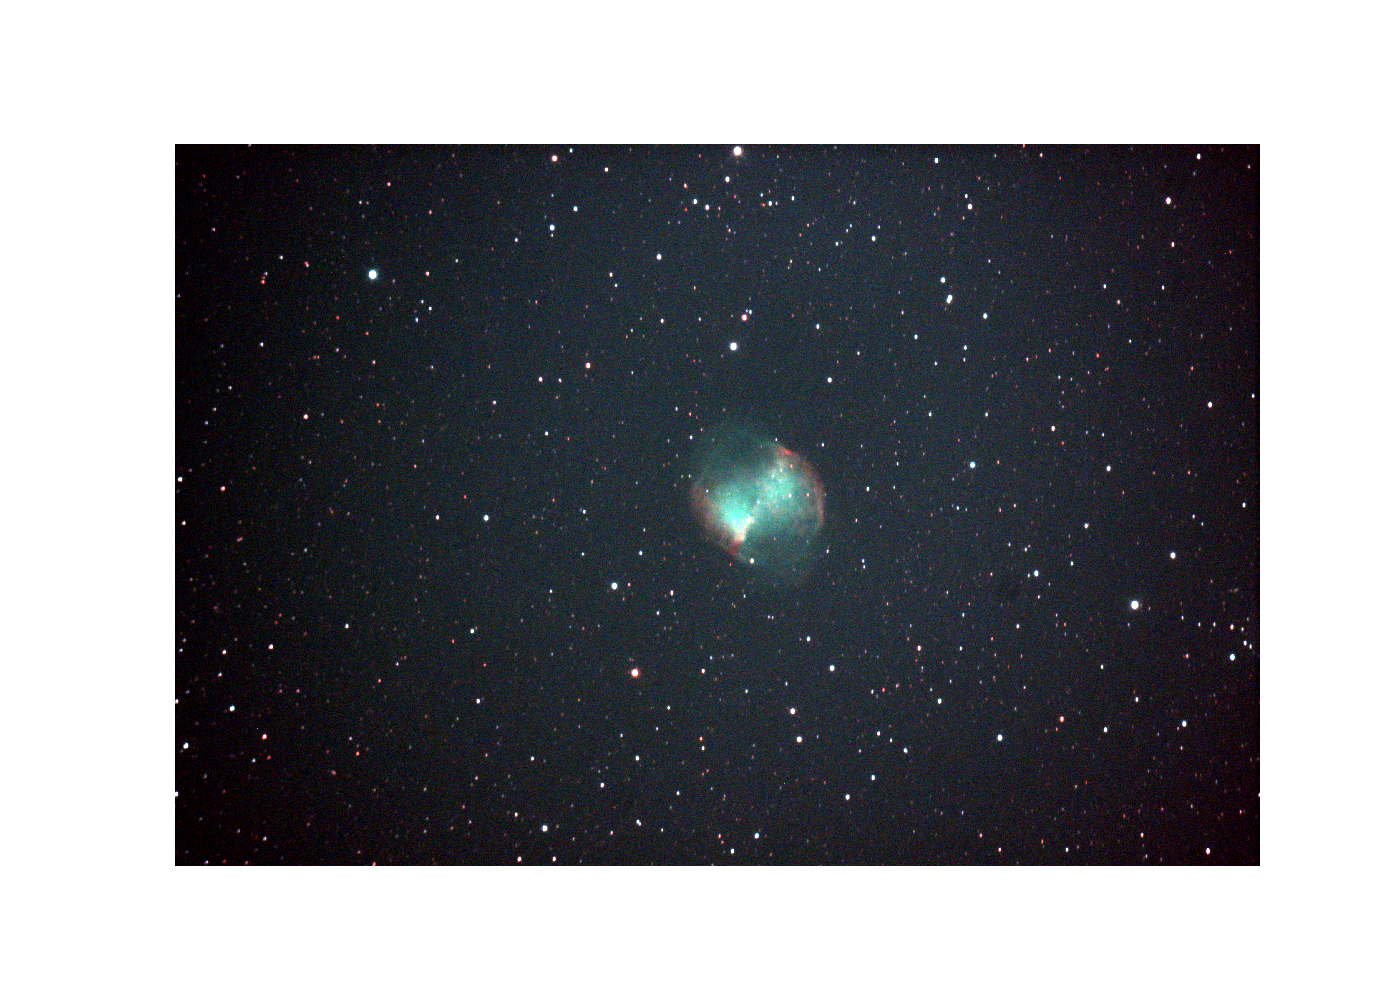

In [120]:
fig, ax = plt.subplots(figsize=(7,5))
ax.axis("off")
mi, ma = 5.15,99.8
x,y,z = sr,sg+sb,su

ss = np.dstack((
    np.clip((x-np.percentile(x,mi))/(np.percentile(x,ma)-np.percentile(x,mi)),0.,1.),
    np.clip((y-np.percentile(y,mi))/(np.percentile(y,ma)-np.percentile(y,mi)),0.,1.),
    np.clip((z-np.percentile(z,mi))/(np.percentile(z,ma)-np.percentile(z,mi)),0.,1.)))
ax.imshow(ss)

In [121]:
rgb_uint8 = (ss * 255.999).astype(np.uint8)

In [122]:
img = Image.fromarray(rgb_uint8)
img.save('myimg.jpeg')